In [27]:
%pip install scikit-learn optuna prettytable matplotlib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np

In [29]:
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

In [30]:
import tensorflow as tf

In [31]:
import matplotlib.pyplot as plt

In [32]:
print(tf.__version__)
print(np.__version__)

2.18.0
2.0.2


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split

In [34]:
def get_mlp_model(input_shape,hidden_layer_one,dropout_one,hidden_layer_two,dropout_two):
    model = Sequential()
    model.add(Dense(hidden_layer_one, activation='elu', input_shape=input_shape))
    if dropout_one !=0:
        model.add(Dropout(dropout_one))
    model.add(Dense(hidden_layer_two, activation='elu'))
    if dropout_two !=0:
        model.add(Dropout(dropout_two))
    model.add(Dense(1))
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer="Adam")

    return model

In [35]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    rrse = np.sqrt(np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    mape = np.mean(np.abs((predicted - trues) / trues)) * 100
    r2 = max(0, 1 - np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    # Calculez les autres mesures d'erreur ici
    return rmse, corr, mae, rae, rrse, mape, r2

## load and aggregate data by month

In [36]:
order_history_data=pd.read_csv('../data/final_data.csv')
order_history_data.head()

,Inflation,Month,Year,pmi,PartNo,Description,Quantity,Sales Price,Total Sales,Swaraj Engines Stock Price,M&M Stock Price,Escorts Kuboto Stock Price
0,7.59,1,2020,250,0503BA0290N-RK,ALFA HUB,85,2118.60,59367,1125.0,532.9,630.0
1,7.59,1,2020,250,0503BA0290N,Front Wheel Hub,318,3536.35,59367,1125.0,532.9,630.0
2,7.59,1,2020,250,0502BA1050N,Alfa Rear Wheel Hub LH,209,1383.36,59367,1125.0,532.9,630.0
3,7.59,1,2020,250,0502BA1060N,Alfa Rear Wheel Hub RH,119,4849.50,59367,1125.0,532.9,630.0
4,7.59,1,2020,250,0602AAB00260N,Brake Drum ALFA,134,2462.26,59367,1125.0,532.9,630.0


In [37]:
X = order_history_data.copy()
y = order_history_data['Quantity']

X_encoded = pd.get_dummies(X, columns=['Description', 'PartNo'])

_, X_temp, _, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=27)
_, X_test, _, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

## Load the optimized model, make predictions on the test data and calculate the errors. You can then compare performance with other models, such as the reference models created previously.

In [38]:
hidden_layer_one=50
hidden_layer_two=100
dropout_one=0
dropout_two=0


model=get_mlp_model(input_shape=(X_test.shape[1],),hidden_layer_one=hidden_layer_one,dropout_one=dropout_one,hidden_layer_two=hidden_layer_two,dropout_two=dropout_two)


checkpoint_filepath = '../checkpoint/bayesian_checkpoint.weights.h5'
# checkpoint_filepath = 'model_checkpoint.h5'

# Load the best weights from the saved checkpoint
model.load_weights(checkpoint_filepath)

# Evaluate the performance of the model on the test set
y_test_pred = model.predict(X_test)

# Calculate performance metrics
rmse2, corr2, mae2, rae2, rrse2, mape2, r2_2 = compute_error(y_test.values, y_test_pred.reshape(y_test_pred.shape[0]))
print("RMSE:", rmse2)
print("Correlation:", corr2)
print("MAE:", mae2)
print("RAE:", rae2)
print("RRSE:", rrse2)
print("MAPE:", mape2)
print("R2:", r2_2)
print("----------------------------------")



49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
RMSE: 1.3380370855580126
Correlation: 0.9999613345000999
MAE: 0.9244380799727908
RAE: 0.007495515275676247
RRSE: 0.008926473702537446
MAPE: 0.6340294022629149
R2: 0.9999203180672379
----------------------------------


/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
# Extract month and year from X_test
months = X_test['Month'].values
years = X_test['Year'].values

# Combine month and year into a single array for plotting
time = years + (months - 1) / 12

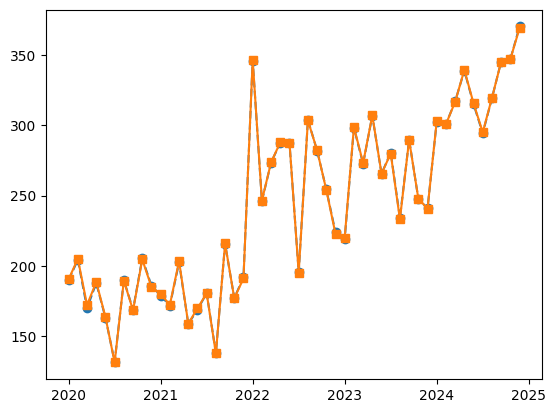

In [44]:
df = pd.DataFrame({'time': time, 'actual': y_test.values, 'predicted': y_test_pred.flatten()})
df_grouped = df.groupby(df['time'].round(1)).mean()  # Aggregating by rounded time

plt.plot(df_grouped.index, df_grouped['actual'], label="Actual Order Quantity", marker='o', linestyle='dashed')
plt.plot(df_grouped.index, df_grouped['predicted'], label="Predicted Order Quantity", marker='s', linestyle='solid')


**Performance comparaison**

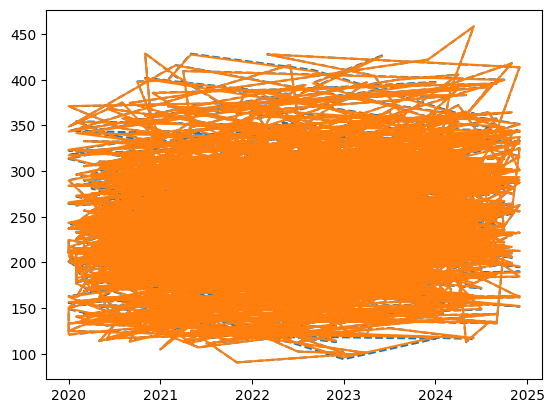

In [45]:
window_size = 5  # Adjust as needed
df['actual_smooth'] = df['actual'].rolling(window=window_size).mean()
df['predicted_smooth'] = df['predicted'].rolling(window=window_size).mean()

plt.plot(df['time'], df['actual_smooth'], label="Smoothed Actual", linestyle='dashed')
plt.plot(df['time'], df['predicted_smooth'], label="Smoothed Predicted", linestyle='solid')


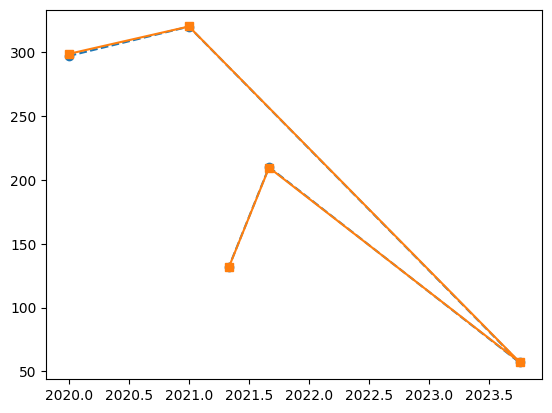

In [75]:
sample_size = 5  # Adjust based on need
sample_indices = np.random.choice(len(time), sample_size, replace=False)

plt.plot(time[sample_indices], y_test.values[sample_indices], label="Actual", marker='o', linestyle='dashed')
plt.plot(time[sample_indices], y_test_pred.flatten()[sample_indices], label="Predicted", marker='s', linestyle='solid')


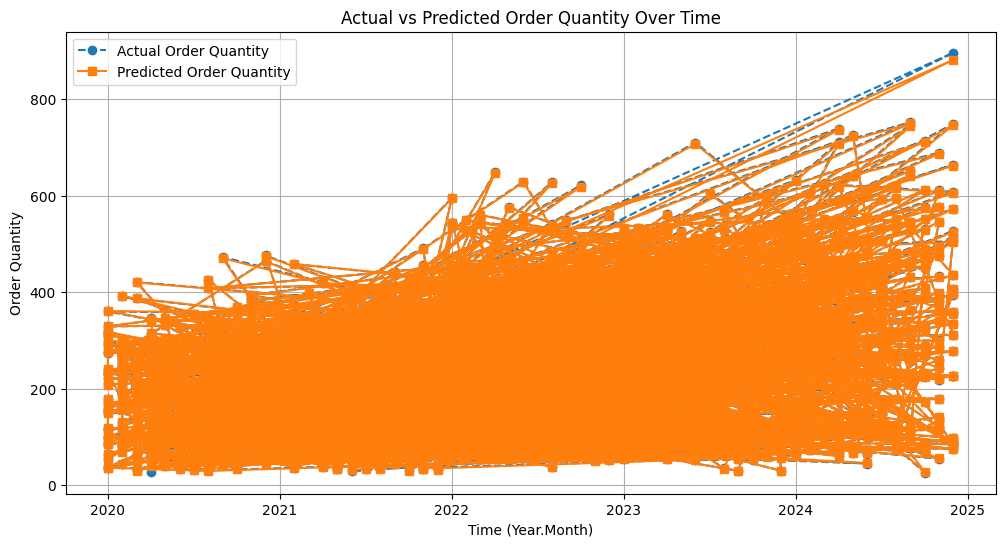

In [ ]:
# Plot actual vs predicted values over time
plt.figure(figsize=(12, 6))
plt.plot(time, y_test.values, label="Actual Order Quantity", marker='o', linestyle='dashed')
plt.plot(time, y_test_pred.flatten(), label="Predicted Order Quantity", marker='s', linestyle='solid')

plt.xlabel("Time (Year.Month)")
plt.ylabel("Order Quantity")
plt.title("Actual vs Predicted Order Quantity Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()